In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
rng = np.random.default_rng(seed=3141592653)
import time
from matplotlib import pyplot as plt
import sympy as sp
from IPython.display import Markdown
%matplotlib inline

In [2]:
def timeit(func_setup, func_eval, ns=[50, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000], max_time=1.):
    print("starting run")
    ts = []
    for n in ns:
        print("  timing n={0}".format(n))
        args = func_setup(n)
        t0 = time.time()
        res = func_eval(*args)
        t1 = time.time()
        ts.append(t1-t0)
        if t1 - t0 > max_time:
            print(f"skip remaining since it took > {max_time:f}s")
            break
    return ns[:len(ts)], ts

In [3]:
def setup_matrix_vector(n):
    mat = np.array(rng.normal(size=(n,n)))
    vec = rng.normal(size=n)
    return mat, vec

def setup_matrix_matrix(n):
    mat1 = rng.normal(size=(n,n))
    mat2 = rng.normal(size=(n,n))
    return mat1, mat2

In [4]:
def matrix_vector_naive(mat, vec):
    if mat.shape[1] != vec.shape[0]:
        raise ValueError('matrix columns must match the length of vector')
    result = np.zeros(mat.shape[0])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            result[i] += mat[i][j] * vec[j]

    return result

   

def matrix_matrix_naive(mat1, mat2):
    if mat1.shape[1] != mat2.shape[0]:
        raise ValueError('column length of matrix_1 must match row length of matrix_2 ')
    result = np.zeros((mat1.shape[0],mat2.shape[1]))
    for i in range(mat1.shape[0]):
        for j in range(mat2.shape[0]):
            for k in range(mat1.shape[1]):
                result[i][j] += mat1[i][k]*mat2[k][j]
    return result

def matrix_vector_numpy(mat, vec):
    return np.dot(mat,vec)

def matrix_matrix_numpy(mat1, mat2):
    return np.dot(mat1,mat2)


In [5]:
ns= [50, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000]
# TODO evaluate runtimes
n1,t1 =timeit(setup_matrix_vector, matrix_vector_naive, ns, max_time=1.)
# TODO evaluate runtimes
n2,t2 =timeit(setup_matrix_vector, matrix_vector_numpy, ns, max_time=1.)
# TODO evaluate runtimes
n3,t3 =timeit(setup_matrix_matrix, matrix_matrix_naive, ns, max_time=1.)
# TODO evaluate runtimes
n4,t4 =timeit(setup_matrix_matrix, matrix_matrix_numpy, ns, max_time=1.)


starting run
  timing n=50
  timing n=100
  timing n=200
  timing n=400
  timing n=600
  timing n=1000
  timing n=2000
skip remaining since it took > 1.000000s
starting run
  timing n=50
  timing n=100
  timing n=200
  timing n=400
  timing n=600
  timing n=1000
  timing n=2000
  timing n=4000
  timing n=6000
  timing n=10000
starting run
  timing n=50
  timing n=100
skip remaining since it took > 1.000000s
starting run
  timing n=50
  timing n=100
  timing n=200
  timing n=400
  timing n=600
  timing n=1000
  timing n=2000
  timing n=4000
skip remaining since it took > 1.000000s


## floating point operations (FLOPs)
let $n$ be the dimension (i.e., matrices of size $n$ x $n$, and vectors of length $n$).
#### (1) Matrix-vector Multiplication:
compute ${y = A.x}$, where A is $n$ x $n$ and $x$ is $n$ x 1.
  
$\rightarrow$ for each value the $n$ rows of A, perform:

$\rightarrow n$ multiplications

$\rightarrow n-1$ additions. 

$\Rightarrow$ total $FLOP_S$ = $n(n+(n-1)) = n(2n-1) \approx 2n^2$

#### (2)Matrix-Matrix Multiplication 
compute C=A.B, where A & B both are $n$ x $n$.

$\rightarrow$ each of $n^2$ entries in C is computed as a dot product of two $n$-length vectors:

$\rightarrow n$ multiplications 

$\rightarrow n-1$ additions

$\Rightarrow$ total $FLOP_S$ =$n^2(2n-1) \approx 2n^3$

#### for $2n$ vs $n$:
it will take $2^3=8$ times longer for $2n$ vs that for $n$


### prefactor calculation
using curve_fit from `scipy.optimize`

$Time \approx C_{fit}{.}\mathcal{O}(n^p)$

p = 2 for matrix-vector operation

p=3 for matrix-matrix operation

In [7]:
def power_law(n,C,p):
    return C*(n**p)

popt_mv,pcov_mv = curve_fit(power_law,n1,t1)
popt_mm,pcov_mm = curve_fit(power_law,n3,t3)

C_mv,p_mv= popt_mv
C_mm,p_mm = popt_mm

/scratch-local/slurm-job-tmp-6631856/ipykernel_138/2339406528.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mm,pcov_mm = curve_fit(power_law,n3,t3)


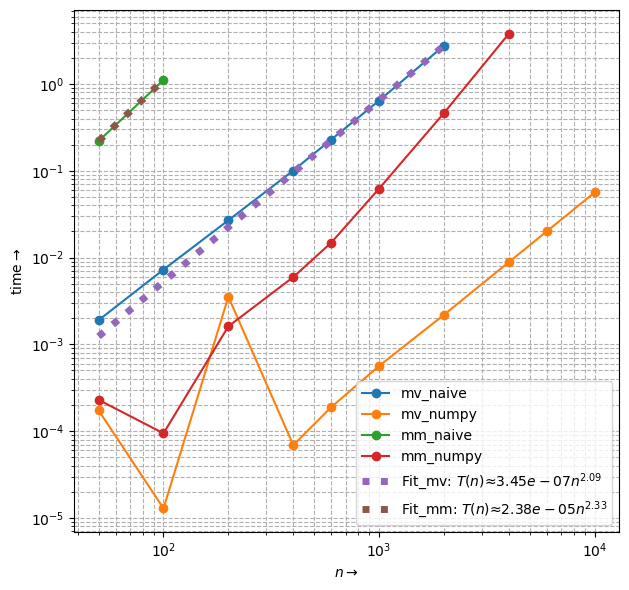

**Fitted curve:** $$C_{mv} \approx 3.45e-07$$ $$C_{mm} \approx 2.38e-05$$

In [8]:
# TODO plot the results
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(n1,t1,'o-',label='mv_naive')
plt.plot(n2,t2,'o-',label='mv_numpy')
plt.plot(n3,t3,'o-',label='mm_naive')
plt.plot(n4,t4,'o-',label='mm_numpy')
#plt.plot(ns,np.array(ns)**3, label= r'$\mathcal{O}(n^3)$')
#plt.plot(ns,np.array(ns)**2, label= r'$\mathcal{O}(n^2)$')
plt.loglog(n1, power_law(n1, *popt_mv), ':',linewidth=5, label=f'Fit_mv: $T(n) ≈ {C_mv:.2e} n^{{{p_mv:.2f}}}$')
plt.loglog(n3, power_law(n3, *popt_mm), ':',linewidth=5, label=f'Fit_mm: $T(n) ≈ {C_mm:.2e} n^{{{p_mm:.2f}}}$')
plt.xlabel(r'$n \rightarrow$')
plt.ylabel(r'time$\rightarrow$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

display(Markdown(f"**Fitted curve:** $$C_{{mv}} \\approx {C_mv:.2e}$$ $$C_{{mm}} \\approx {C_mm:.2e}$$"))

### prefactors for naive approach 

the prefactor includes effects from:

$\rightarrow$ Memory access speed

$\rightarrow$ CPU/GPU instruction efficiency

$\rightarrow$ Python/Numpy overhead vs raw loops

**the prefactor gives information about _how efficiently_ the system(*Hardware*) runs the code**

In [9]:
def setup_matrix_vector_complex(n):
    return rng.normal(size=(n,n)) + 1j*rng.normal(size=(n,n)), rng.normal(size=n) + 1j*rng.normal(size=n)

def setup_matrix_matrix_complex(n):
    return rng.normal(size=(n,n)) + 1j*rng.normal(size=(n,n)), rng.normal(size=(n,n)) + 1j*rng.normal(size=(n,n))

In [ ]:
# TODO evaluate runtimes with complex arguments

nc_mm,tc_mm =timeit(setup_matrix_matrix_complex, matrix_matrix_numpy, ns, max_time=1.)

nc_mv,tc_mv =timeit(setup_matrix_vector_complex, matrix_vector_numpy, ns, max_time=1.)

ncn_mm,tcn_mm =timeit(setup_matrix_matrix_complex, matrix_matrix_naive, ns, max_time=1.)

ncn_mv,tcn_mv =timeit(setup_matrix_vector_complex, matrix_vector_naive, ns, max_time=1.)

starting run
  timing n=50
  timing n=100
  timing n=200
  timing n=400
  timing n=600
  timing n=1000
  timing n=2000
skip remaining since it took > 1.000000s
starting run
  timing n=50
  timing n=100
  timing n=200
  timing n=400
  timing n=600
  timing n=1000
  timing n=2000
  timing n=4000
  timing n=6000
  timing n=10000


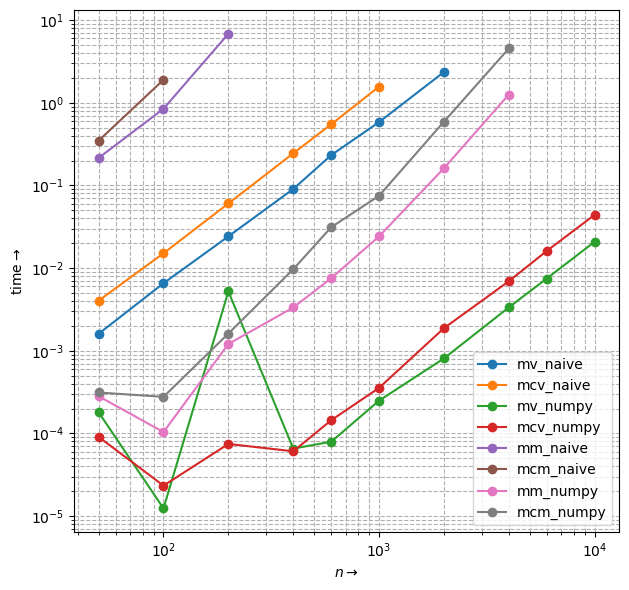

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plt.plot(n1,t1,'o-',label='mv_naive')
plt.plot(ncn_mv,tcn_mv,'o-',label='mcv_naive')

plt.plot(n2,t2,'o-',label='mv_numpy')
plt.plot(nc_mv,tc_mv,'o-',label='mcv_numpy')

plt.plot(n3,t3,'o-',label='mm_naive')
plt.plot(ncn_mm,tcn_mm,'o-',label='mcm_naive')

plt.plot(n4,t4,'o-',label='mm_numpy')
plt.plot(nc_mm,tc_mm,'o-',label='mcm_numpy')

#plt.plot(ns,np.array(ns)**3, label= r'$\mathcal{O}(n^3)$')
#plt.plot(ns,np.array(ns)**2, label= r'$\mathcal{O}(n^2)$')
#plt.loglog(n1, power_law(n1, *popt_mv), ':',linewidth=5, label=f'Fit_mv: $T(n) ≈ {C_mv:.2e} n^{{{p_mv:.2f}}}$')
#plt.loglog(n3, power_law(n3, *popt_mm), ':',linewidth=5, label=f'Fit_mm: $T(n) ≈ {C_mm:.2e} n^{{{p_mm:.2f}}}$')
plt.xlabel(r'$n \rightarrow$')
plt.ylabel(r'time$\rightarrow$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [ ]:
tc